In [1]:
### Importing Libraries

import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt

import os
from PIL import Image
from pathlib import Path
import csv

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
import keras

Using TensorFlow backend.


In [2]:
### Extracting the features from our dataset
# We will work with the zero crossing rate, spectral centroid, chroma frequencies, 
# spectral roll-off, and the Mel-frequency cepstral coefficients (1 to 20)

# First, we will save the spectrogram for every song in order to extract the above features. This will also be useful
# for a Convolutional Neural Network approach later on.

cmap = plt.get_cmap('plasma')
plt.figure(figsize=(10,10))
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
for genre in genres:
    Path(f'spectrograms/{genre}').mkdir(parents=True, exist_ok=True)     
    for filename in os.listdir(f'./genres/{genre}'):
        songname = f'./genres/{genre}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=5)
        plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
        plt.axis('off');
        plt.savefig(f'spectrograms/{genre}/{filename[:-3].replace(".", "")}.png')
        plt.clf()

//anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:7725: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


<Figure size 720x720 with 0 Axes>

In [3]:
header = 'filename zero_crossing_rate spectral_centroid spectral_bandwidth chroma_frequencies spectral_roll_off'
for i in range(1,21):
    header += f' mfcc{i}' 
header += ' label'
header = header.split()

def create_line(songname, filename, genre):
    y, sr = librosa.load(songname, mono=True, duration=30)
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    
    new_line = f'{filename} {np.mean(zcr)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(chroma_stft)} {np.mean(rolloff)}'
    for mfcc_index in mfcc:
        new_line += f' {np.mean(mfcc_index)}'
    new_line += f' {genre}'
    return new_line
    
with open('data.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header)
for genre in genres:
    for filename in os.listdir(f'./genres/{genre}'):
        songname = f'./genres/{genre}/{filename}'
        new_line = create_line(songname, filename, genre)
        file = open('data.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(new_line.split())

In [4]:
data = pd.read_csv('data.csv')
data.head()

,filename,zero_crossing_rate,spectral_centroid,spectral_bandwidth,chroma_frequencies,spectral_roll_off,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,blues.00043.au,0.087165,2155.654923,2372.403604,0.399025,5012.019693,-109.165359,100.621498,-8.614720,47.358475,...,6.585774,-8.642620,4.912258,-15.442804,1.538751,-6.732474,1.417775,-3.961750,3.287461,blues
1,blues.00012.au,0.069124,1361.045467,1567.804596,0.269320,2739.625101,-207.208084,132.799179,-15.438985,60.986721,...,-0.613249,0.384878,2.605127,-5.188923,-9.527454,-9.244393,-2.848273,-1.418707,-5.932606,blues
2,blues.00026.au,0.051988,1198.607665,1573.308974,0.278484,2478.376680,-284.819519,108.785629,9.131957,51.259022,...,-3.303735,1.601560,2.660516,3.323455,3.258921,-4.551105,0.493845,5.937066,3.231545,blues
3,blues.00077.au,0.111526,2206.771246,2191.473506,0.408876,4657.388504,-29.010986,104.532921,-30.974207,38.156387,...,10.786453,-10.558812,6.877709,-10.294858,6.967846,-10.256099,0.705014,-6.000722,1.348956,blues
4,blues.00084.au,0.113397,2061.150735,2085.159448,0.396258,4221.149475,-38.965939,112.039833,-31.817036,38.240833,...,13.327048,-10.921602,9.795614,-5.031277,7.200983,-6.754969,2.663612,-4.380430,0.414055,blues


In [5]:
data.drop(['filename'], axis=1, inplace=True)
data.head()

,zero_crossing_rate,spectral_centroid,spectral_bandwidth,chroma_frequencies,spectral_roll_off,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,0.087165,2155.654923,2372.403604,0.399025,5012.019693,-109.165359,100.621498,-8.614720,47.358475,-6.555960,...,6.585774,-8.642620,4.912258,-15.442804,1.538751,-6.732474,1.417775,-3.961750,3.287461,blues
1,0.069124,1361.045467,1567.804596,0.269320,2739.625101,-207.208084,132.799179,-15.438985,60.986721,0.725807,...,-0.613249,0.384878,2.605127,-5.188923,-9.527454,-9.244393,-2.848273,-1.418707,-5.932606,blues
2,0.051988,1198.607665,1573.308974,0.278484,2478.376680,-284.819519,108.785629,9.131957,51.259022,18.111256,...,-3.303735,1.601560,2.660516,3.323455,3.258921,-4.551105,0.493845,5.937066,3.231545,blues
3,0.111526,2206.771246,2191.473506,0.408876,4657.388504,-29.010986,104.532921,-30.974207,38.156387,-7.991166,...,10.786453,-10.558812,6.877709,-10.294858,6.967846,-10.256099,0.705014,-6.000722,1.348956,blues
4,0.113397,2061.150735,2085.159448,0.396258,4221.149475,-38.965939,112.039833,-31.817036,38.240833,-6.320414,...,13.327048,-10.921602,9.795614,-5.031277,7.200983,-6.754969,2.663612,-4.380430,0.414055,blues


In [6]:
labels = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(labels)

scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:,:-1], dtype=float))

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(800, 25) (800,)
(200, 25) (200,)


In [7]:
from sklearn.metrics import confusion_matrix
from sklearn import neighbors
import seaborn as sns

svm = SVC(kernel='linear' , C=0.01)
svm.fit(X_train, y_train)
prediction_SVM = svm.predict(X_test)
print('SVM Training Score: {}'.format(svm.score(X_train, y_train)))
print('SVM Test Score: {}'.format(svm.score(X_test, y_test)))

random_forest = RandomForestClassifier(n_estimators=15)
random_forest.fit(X_train,y_train)
prediction_forest = random_forest.predict(X_test)
print('Random Forest Training Score: {}'.format(random_forest.score(X_train, y_train)))
print('Random Forest Test Score: {}'.format(random_forest.score(X_test, y_test)))

scores = []
for number in range(2, 20):
    knn = neighbors.KNeighborsClassifier(n_neighbors=number)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))

number = scores.index(max(scores)) + 2

knn = neighbors.KNeighborsClassifier(n_neighbors=number)
knn.fit(X_train, y_train)
scores.append(knn.score(X_test, y_test))
knn_predictions = knn.predict(X_test)
print('KNN Training Score: {}'.format(knn.score(X_train, y_train)))
print('KNN Test Score: {}'.format(knn.score(X_test, y_test)))

SVM Training Score: 0.53875
SVM Test Score: 0.505
Random Forest Training Score: 0.99625
Random Forest Test Score: 0.56
KNN Training Score: 0.64375
KNN Test Score: 0.62


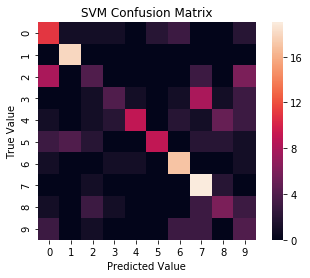

In [8]:
mat = confusion_matrix(y_test, prediction_SVM)
sns.heatmap(mat, square=True, annot=False, cbar=True)
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.show()

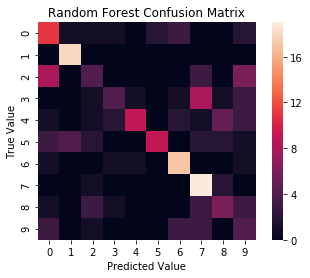

In [9]:
mat = confusion_matrix(y_test, prediction_SVM)
sns.heatmap(mat, square=True, annot=False, cbar=True)
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.show()

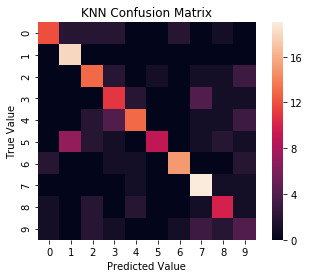

In [10]:
mat = confusion_matrix(y_test, knn_predictions)
sns.heatmap(mat, square=True, annot=False, cbar=True)
plt.title('KNN Confusion Matrix')
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.show()

In [11]:
from keras import models
from keras import layers

x_val = X_train[:200]
partial_x_train = X_train[200:]

y_val = y_train[:200]
partial_y_train = y_train[200:]


model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))

model.add(layers.Dense(128, activation='relu'))

model.add(layers.Dense(64, activation='relu'))

model.add(layers.Dense(10, activation='softmax'))

In [12]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [13]:
history = model.fit(partial_x_train, partial_y_train, epochs=50, batch_size=512, validation_data=(x_val, y_val))

Train on 600 samples, validate on 200 samples
Epoch 1/50
600/600 [==============================] - 0s 373us/step - loss: 2.3328 - accuracy: 0.0917 - val_loss: 2.2213 - val_accuracy: 0.2050
Epoch 2/50
600/600 [==============================] - 0s 24us/step - loss: 2.1890 - accuracy: 0.2783 - val_loss: 2.1330 - val_accuracy: 0.3250
Epoch 3/50
600/600 [==============================] - 0s 21us/step - loss: 2.0827 - accuracy: 0.3750 - val_loss: 2.0561 - val_accuracy: 0.3150
Epoch 4/50
600/600 [==============================] - 0s 22us/step - loss: 1.9875 - accuracy: 0.3967 - val_loss: 1.9808 - val_accuracy: 0.3100
Epoch 5/50
600/600 [==============================] - 0s 21us/step - loss: 1.8931 - accuracy: 0.4100 - val_loss: 1.9045 - val_accuracy: 0.3050
Epoch 6/50
600/600 [==============================] - 0s 21us/step - loss: 1.8009 - accuracy: 0.4183 - val_loss: 1.8313 - val_accuracy: 0.3000
Epoch 7/50
600/600 [==============================] - 0s 20us/step - loss: 1.7137 - accuracy: 0

In [14]:
test_loss, test_accuracy = model.evaluate(X_test,y_test)
print('test_acc: {}'.format(test_accuracy))

200/200 [==============================] - 0s 33us/step
test_acc: 0.6499999761581421


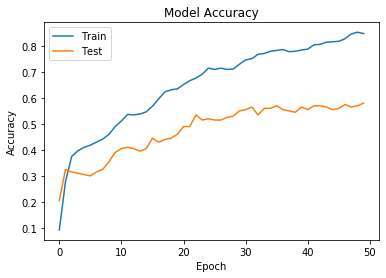

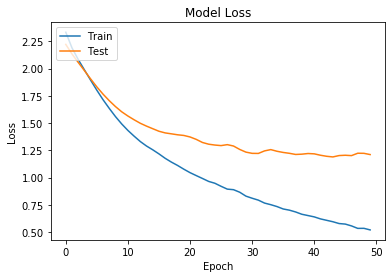

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()